In [1]:
from IPython.display import display
from model.utility.default_parameters import default_params_soros as params
from model.utility.default_initial_state import default_initial_soros as initial_state
from model.utility.initial_state_functions import fill_in_initial_state
from model.run import load_config, run, post_processing

# Fill in initial state
initial_state = fill_in_initial_state(initial_state, params)

# Set the params for runs and timesteps
number_runs = 3
number_steps = 100

# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps,
                 psub_scenario_option = "Soros")

# Run the experiment
raw = run(exp)

# Parse the raw data
df = post_processing(raw)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 26, 6, 69)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 26, 6, 69)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 27.99s


In [26]:
mapping = {'soros_short_amount': {},
          'soros_short_timing': {},
          "soros_close_out_timing": {},
          "soros_long_position": {}}


for i, x in enumerate(params['soros_short_amount']):
    mapping["soros_short_amount"][i] = x

for i, x in enumerate(params['soros_short_timing']):
    mapping["soros_short_timing"][i] = x
    
for i, x in enumerate(params['soros_close_out_timing']):
    mapping["soros_close_out_timing"][i] = x
    
for i, x in enumerate(params['soros_long_position']):
    mapping["soros_long_position"][i] = x
    
df["soros_short_amount"] = df['subset'].map(mapping['soros_short_amount'])
df["soros_short_timing"] = df['subset'].map(mapping['soros_short_timing'])
df["soros_close_out_timing"] = df['subset'].map(mapping['soros_close_out_timing'])
df["soros_long_position"] = df['subset'].map(mapping['soros_long_position'])

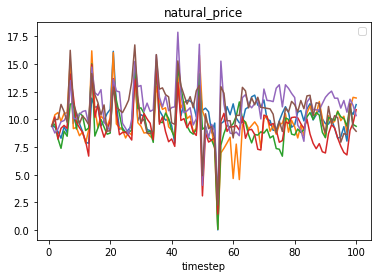

In [3]:
from model.utility.visualization import plot_all_sims, plot_grouped_variables_average

plot_all_sims(["natural_price"], df)

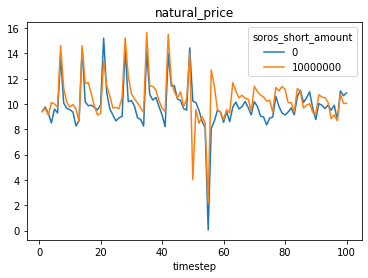

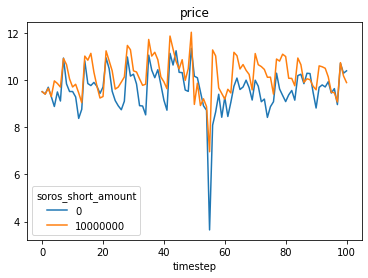

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

In [4]:
# Plot the average values for natural price by the groups of supply and demand factor
variables_to_plot = ["natural_price", "price"]
grouping_variables = ["soros_short_amount"]

plot_grouped_variables_average(variables_to_plot,
                               grouping_variables,
                               df)

In [5]:
params['soros_short_timing']

[None, 50]

In [6]:
df["soros_revenue"].max()

143610145.97078648

In [7]:
df["soros_revenue"].min()

0.0

In [10]:
df["soros_revenue"]

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
601    0.0
602    0.0
603    0.0
604    0.0
605    0.0
Name: soros_revenue, Length: 606, dtype: float64

In [14]:
df.groupby("subset").sum()["soros_revenue"]

subset
0    3.765283e+08
1    5.339920e+08
Name: soros_revenue, dtype: float64

In [21]:
df.pivot("timestep", "unique_id", "soros_revenue").sum()

unique_id
0-0-1    1.436101e+08
0-0-2    1.205675e+08
0-0-3    1.123507e+08
0-1-1    1.508001e+08
0-1-2    1.798313e+08
0-1-3    2.033605e+08
dtype: float64

In [34]:
import pandas as pd
revenue = df.groupby("unique_id")[["soros_revenue"]].sum()
descriptors = df.groupby("unique_id")[['soros_short_amount',
 'soros_short_timing',
 'soros_close_out_timing',
 'soros_long_position']].last()
df2 = pd.concat([revenue, descriptors], axis=1)

In [35]:
df2

,soros_revenue,soros_short_amount,soros_short_timing,soros_close_out_timing,soros_long_position
unique_id,,,,,
0-0-1,1.436101e+08,0,NaN,55,20000000
0-0-2,1.205675e+08,0,NaN,55,20000000
0-0-3,1.123507e+08,0,NaN,55,20000000
0-1-1,1.508001e+08,10000000,50.0,55,20000000
0-1-2,1.798313e+08,10000000,50.0,55,20000000
0-1-3,2.033605e+08,10000000,50.0,55,20000000


In [36]:
2.033605e+08 / 20000000 

10.168025

In [37]:
print(" NEED TO ADJUST IT TO MAKE SURE NET FLOW UNITS ARE CORRECT")

 NEED TO ADJUST IT TO MAKE SURE NET FLOW UNITS ARE CORRECT


In [39]:
print("MIGHT NEED TO DO MID POINT VALUE / START VALUE * AMOUNT")

MIGHT NEED TO DO MID POINT VALUE / START VALUE * AMOUNT
